# Project setup

Import necessary libraries

In [51]:
# System
import os
import shutil

# Image handling
from PIL import Image

# Numerical
import numpy as np
import pandas as pd

# Reproducability
import random
random.seed(42)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [52]:
DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

TRAIN_DIR = os.path.join(DIR, 'CASIA-HWDB_Train/Train/')
TEST_DIR = os.path.join(DIR, 'CASIA-HWDB_Test/Test/')

DATA_DIR = 'data/'
DATA_TRAIN_DIR = os.path.join(DATA_DIR, 'train')
DATA_VAL_DIR = os.path.join(DATA_DIR, 'val')
DATA_TEST_DIR = os.path.join(DATA_DIR, 'test')

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [53]:
image_classes_train = set(os.listdir(TRAIN_DIR))
image_classes_test = set(os.listdir(TEST_DIR))
print(len(image_classes_train), image_classes_train)
print(len(image_classes_test), image_classes_test)

if image_classes_train == image_classes_test:
    print('The same classes are in each folder')
    # image_classes = set(['零', '一', '二'])
    # image_classes = set(['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十'])
    image_classes = image_classes_train
else:
    print('The two folders contain different classes')


178 {'认', '岁', '校', '没', '欢', '们', '影', '妈', '几', '工', '火', '在', '十', '么', '后', '吗', '回', '小', '时', '院', '对', '猫', '字', '有', '叫', '家', '谢', '椅', '亮', '我', '书', '昨', '分', '车', '块', '视', '桌', '一', '很', '四', '系', '去', '读', '北', '京', '午', '先', '看', '吃', '中', '天', '你', '六', '生', '星', '衣', '好', '里', '说', '那', '做', '住', '租', '了', '七', '今', '出', '她', '钟', '热', '茶', '脑', '老', '习', '八', '再', '饭', '这', '女', '二', '爱', '果', '学', '语', '点', '些', '电', '月', '个', '想', '五', '本', '样', '不', '上', '面', '明', '多', '爸', '儿', '水', '识', '怎', '馆', '觉', '九', '名', '年', '是', '机', '见', '冷', '子', '店', '汉', '谁', '兴', '站', '高', '期', '三', '医', '漂', '气', '大', '会', '太', '能', '请', '什', '坐', '友', '菜', '买', '同', '飞', '西', '狗', '米', '前', '雨', '来', '的', '下', '喝', '钱', '喂', '喜', '起', '杯', '打', '候', '商', '服', '客', '他', '姐', '作', '人', '现', '哪', '日', '朋', '和', '关', '听', '睡', '写', '师', '开', '零', '国', '都', '少', '呢', '苹', '东', '话'}
178 {'认', '岁', '校', '没', '欢', '们', '影', '妈', '几', '工', '火', '在', '十', '么', '后', '吗', '回', '小', '时', '院', 

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [54]:
# Remove old data
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
    
#Create the new directory
os.mkdir(DATA_DIR)
for dir in (DATA_TRAIN_DIR, DATA_TEST_DIR, DATA_VAL_DIR):
    for image_class in image_classes:
        path = os.path.join(dir, image_class)
        os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DATA_DIR` variable.

In [55]:
# Store how many of each class there are
class_counts = {}
max_images_per_class = 70

TRAIN_SPLIT = 5/7
TEST_SPLIT  = 1/7
VAL_SPLIT   = 1/7

for image_class in image_classes:
    images = []

    # Fetch images from train dir
    train_path = os.path.join(TRAIN_DIR, image_class)
    images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

    # Fetch images from test dir
    test_path = os.path.join(TEST_DIR, image_class)
    images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

    # Update class_counts
    num_images = min(len(images), max_images_per_class)
    class_counts[image_class] = num_images

    # Select the images
    # images = images[:num_images]
    images = random.choices(images, k=num_images)

    # Define the bounds of the splits
    train = (DATA_TRAIN_DIR, 0, int(TRAIN_SPLIT*num_images))
    test = (DATA_TEST_DIR, train[2], train[2] + int(TEST_SPLIT*num_images))
    val = (DATA_VAL_DIR, test[2], num_images)

    # Iterate over the splits and images and copy them to the data directory
    for split in (train, test, val):
        for i, image in enumerate(images[split[1]:split[2]]):
            new_filename = f"{i+1}.png"
            destination_path = os.path.join(split[0], image_class, new_filename)
            shutil.copy(image, destination_path)

Now lets check how many images we have in each class and see how balanced the classes are.

In [56]:
df_class_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df_class_counts.reset_index(inplace=True)
df_class_counts.columns = ['Character', 'Count']

print(df_class_counts)
print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

    Character  Count
0           认     70
1           岁     70
2           校     70
3           没     70
4           欢     70
..        ...    ...
173         少     70
174         呢     70
175         苹     70
176         东     70
177         话     70

[178 rows x 2 columns]
       Count
count  178.0
mean    70.0
std      0.0
min     70.0
5%      70.0
25%     70.0
50%     70.0
75%     70.0
95%     70.0
max     70.0


From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [57]:
mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

Empty DataFrame
Columns: [Character, Count]
Index: []


As we can see, the imbalance is very minimal. For now we can move on to the next step, and revisit this if the performance of our model is being affected by this imbalance.

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [58]:
# Loop through each subdirectory and file in the directory
for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        if image.lower().endswith('.png'):
            # Construct the full path
            file_path = os.path.join(subdir, image)

            # Open the image
            with Image.open(file_path) as img:
                # Check if the image is not grayscale
                if img.mode != 'L':
                    print(f"{file_path} is not a black and white image.")
        else:
            print("Not a png file: ")

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [59]:
image_sizes = []

# Iterate through all the images and check if any do not have a 1:1 aspect ratio
for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            image_sizes.append(img.size[0])
            
            if img.size[0] != img.size[1]:
                print(file_path, img.size)

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 15


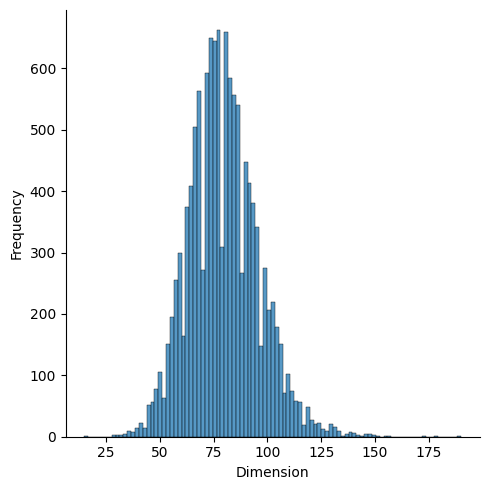

In [60]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
sns.displot(image_sizes)
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will remove that image.

In [61]:
# Iterate through all the images and resize to a fixed size
for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            current_size = img.size
            if img.size[0] < 5:
                os.remove(file_path)
            
            IMAGE_SIZE = 50
            
            resized_img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            resized_img.save(file_path)

# Data Augmentation

Now that all the images are the same size, we can begin with augmenting the images. This will involve randomly flipping rotating the images to create more data for the model to train on and prevent overfitting.
Note, there are many more augmentation techniques that can be used such as scaling, randomly cropping, randomly erasing, distorting, and blurring, but for now we will only use rotation and flipping.

In [62]:
# How many augmented images should be generated as a percentage of the current
percent_augmented = 0.5 # 0 to 1
augments = [(0, 90), (0, 180), (0, 270), (1, 0), (1, 90), (1, 180), (1, 270)]

# Iterate through all the images and resize to a fixed size
for subdir, dirs, images in os.walk(DATA_TRAIN_DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            if random.random() <= percent_augmented:
                augmented_img = img

                augment = random.choice(augments)

                if augment[0]:
                    augmented_img = augmented_img.transpose(Image.FLIP_LEFT_RIGHT)
                if augment[1]:
                    augmented_img = augmented_img.rotate(augment[1])

                name, extension = image.rsplit('.', 1)
                save_file_path = os.path.join(subdir, f"{name}.aug.{extension}")

                augmented_img.save(save_file_path)

In [63]:
import glob

png_files = glob.glob(f"{DATA_DIR}/**/*.png", recursive=True)
aug_png_files = glob.glob(f"{DATA_DIR}/**/*.aug.png", recursive=True)

print(f"Number of .png files in the data directory: {len(png_files)}")
print(f"Number of .aug.png files in the data directory: {len(aug_png_files)}")

Number of .png files in the data directory: 16957
Number of .aug.png files in the data directory: 4497


# Mean and standard deviation of dataset

In [64]:
# Iterate through all the images and resize to a fixed size
pixel_sum = np.zeros(1)
pixel_sum_sq = np.zeros(1)
pixel_count = 0
pixels_per_image = IMAGE_SIZE * IMAGE_SIZE

for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            image_array = np.array(img) / 255.0
            pixel_sum += image_array.sum()
            pixel_sum_sq += (image_array ** 2).sum()
            pixel_count += pixels_per_image

mean = pixel_sum / pixel_count
std = np.sqrt(pixel_sum_sq / pixel_count - mean ** 2)

# Feature Extraction

First we import the necessary libraries

In [65]:
import torch
from torchvision.models import resnet50
import torchvision.transforms.v2 as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

Next, we define the CNN model we will be using.

In [66]:
# Load pre-trained ResNet
resnet = resnet50(pretrained=True)

# Remove the last fully connected layer for feature extraction
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

# Set model to evaluation mode
resnet.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
])

/home/miikey_lol/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/miikey_lol/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Now, we define where the images are stored, and appropriate loaders for the images.

In [67]:
train_folder = ImageFolder(root=DATA_TRAIN_DIR, transform=transform)
val_folder = ImageFolder(root=DATA_VAL_DIR, transform=transform)
test_folder = ImageFolder(root=DATA_TEST_DIR, transform=transform)

BATCH_SIZE = 64

train_loader = DataLoader(train_folder, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_folder, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_folder, batch_size=BATCH_SIZE, shuffle=False)

Now we define a function, where given a loader, it will extract features from the images using the CNN model we defined earlier.

In [68]:
def extract_features(folder, loader, model):
    features = []
    labels = []

    with torch.no_grad():
        for images, label in loader:
            images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            output = model(images)
            
            feature_batch = output.cpu().detach().numpy().flatten().reshape(-1, 2048)
            features.extend(feature_batch)
            labels.extend(label.numpy())

    return features, labels

In [69]:
train_features, train_labels = extract_features(train_folder, train_loader, resnet)
val_features, val_labels = extract_features(test_folder, val_loader, resnet)
test_features, test_labels = extract_features(val_folder, test_loader, resnet)

In [71]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(train_features, train_labels)

y_pred = logreg.predict(val_features)

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(val_labels, val_pred)
cnf_matrix

array([[10,  0,  0, ...,  0,  0,  0],
       [ 0,  7,  0, ...,  0,  0,  0],
       [ 0,  0,  8, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  0,  0,  4]])

Text(0.5, 427.9555555555555, 'Predicted label')

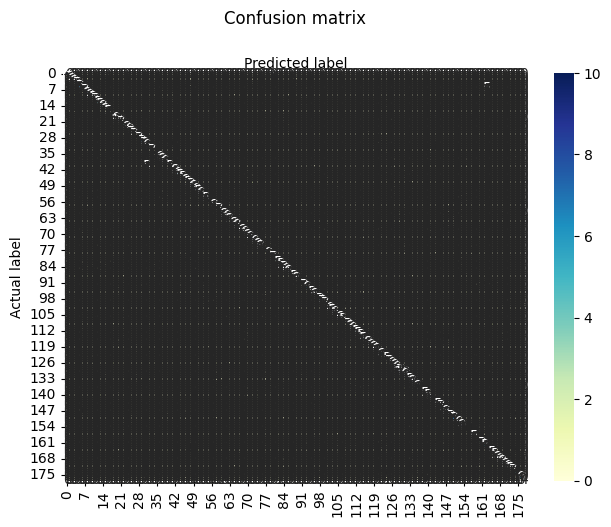

In [73]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
tick_marks = np.arange(len(image_classes))
plt.xticks(tick_marks, image_classes)
plt.yticks(tick_marks, image_classes)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')


ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [74]:
from sklearn.metrics import classification_report
target_names = image_classes
print(classification_report(val_labels, val_pred, target_names=target_names))

              precision    recall  f1-score   support

           认       1.00      1.00      1.00        10
           岁       0.78      0.70      0.74        10
           校       0.80      0.80      0.80        10
           没       0.62      0.80      0.70        10
           欢       0.88      0.70      0.78        10
           们       0.44      0.70      0.54        10
           影       0.25      0.30      0.27        10
           妈       0.58      0.70      0.64        10
           几       0.57      0.80      0.67        10
           工       0.57      0.80      0.67        10
           火       0.71      0.50      0.59        10
           在       0.70      0.70      0.70        10
           十       0.56      0.50      0.53        10
           么       0.45      0.50      0.48        10
           后       0.73      0.80      0.76        10
           吗       0.73      0.80      0.76        10
           回       0.56      0.50      0.53        10
           小       0.67    